## ATAC + MULTIOME (germ cells september 2021)

### Label transfer with Seurat 

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_july2021/figures_germ/'

In [2]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
import rpy2.rinterface_lib.callbacks
import logging

In [5]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [6]:
import anndata2ri
anndata2ri.activate()

In [7]:
%load_ext rpy2.ipython

In [8]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

**Load data**

In [9]:
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/germcells_july2021/"
experiment_prefix = 'germcells_'

Try to use the gene accessibility scores computed with Emma's method and integrate with matched scRNAseq samples annotated by Luz 

In [10]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
table(ATAC_geneScores@meta.data$individual)

 [1]   15  604    5   55   70    2   14    9  660  141  188  542  345   92 1903
[16]  266 2596 1089  305


In [11]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE, verbose = TRUE)

RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
table(RNAseq@meta.data$donor)

 [1]    3  130    4   16    1    2    3   11  310    1   32 1704  422    2   36
[16]    2    1    3    3    1  144    3   12    9  104   46   51   17  141   88
[31]   23    3  235  234  113  197   71   19    1    2


In [12]:
%%R -i RNAseq

print(table(RNAseq@meta.data$germ_celltype)) 


               GC               PGC            oocyte     oogonia_STRA8 
              600               600               600               600 
  oogonia_meiotic        pre_oocyte pre_spermatogonia 
              600               600               600 


**Try label transfer with major cluster annotations**

In [13]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:25, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$germ_celltype, dims = 1:25, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [14]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [15]:
predicted_probabilities

PGC        GC    oocyte  pre-oocyte  \
01-AAACAGCCAGCCAGAA-1  0.138339  0.037544  0.093974    0.129238   
01-AAACAGCCATCCAGGT-1  0.046551  0.199837  0.000000    0.036332   
01-AAACATGCATTGTCCT-1  0.031609  0.499306  0.000000    0.017368   
01-AAACCGAAGCTTCCCG-1  0.000000  0.000000  0.118440    0.825391   
01-AAACCGAAGGCGAATA-1  0.086227  0.352327  0.000000    0.018211   
...                         ...       ...       ...         ...   
26-TCGGGACGTCTGATTG-1  0.889978  0.016830  0.000000    0.000000   
26-TCTCAGCAGTATACCC-1  0.048442  0.591415  0.000000    0.007328   
26-TGAGCCGAGTACAGAT-1  0.579565  0.056784  0.015456    0.000000   
26-TGGCCTTCATCCCTCA-1  0.023082  0.163909  0.041934    0.082629   
26-TGTGGCGAGACACAAT-1  0.000000  0.542753  0.000000    0.059478   

                       oogonia-STRA8  oogonia-meiotic  pre-spermatogonia  \
01-AAACAGCCAGCCAGAA-1       0.209017         0.223736           0.168152   
01-AAACAGCCATCCAGGT-1       0.551939         0.080442           0.084899   
01-AAACATGCATTGTCCT-1       0.381851         0.007569           0.062296   
01-AAACCGAAGCTTCCCG-1       0.017007         0.039162           0.000000   
01-AAACCGAAGGCGAATA-1       0.504056         0.036216           0.002962   
...                              ...              ...                ...   
26-TCGGGACGTCTGATTG-1       0.018689         0.000000           0.074503   
26-TCTCAGCAGTATACCC-1       0.257754         0.033748           0.061312   
26-TGAGCCGAGTACAGAT-1       0.083540         0.015236           0.249419   
26-TGGCCTTCATCCCTCA-1       0.605175         0.040468           0.042803   
26-TGTGGCGAGACACAAT-1       0.204413         0.119572           0.073784   

                            max  
01-AAACAGCCAGCCAGAA-1  0.223736  
01-AAACAGCCATCCAGGT-1  0.551939  
01-AAACATGCATTGTCCT-1  0.499306  
01-AAACCGAAGCTTCCCG-1  0.825391  
01-AAACCGAAGGCGAATA-1  0.504056  
...                         ...  
26-TCGGGACGTCTGATTG-1  0.889978  
26-TCTCAGCAGTATACCC-1  0.591415  
26-TGAGCCGAGTACAGAT-1  0.579565  
26-TGGCCTTCATCCCTCA-1  0.605175  
26-TGTGGCGAGACACAAT-1  0.542753  

[8901 rows x 8 columns]

In [16]:
predicted_probabilities.columns

Index(['PGC', 'GC', 'oocyte', 'pre-oocyte', 'oogonia-STRA8', 'oogonia-meiotic',
       'pre-spermatogonia', 'max'],
      dtype='object')

Replace dashes with underscores as stupid R changes them

In [17]:
predicted_probabilities.columns = ['PGC', 'GC', 'oocyte', 'pre_oocyte', 'oogonia_STRA8', 'oogonia_meiotic',
       'pre_spermatogonia', 'max']

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [18]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")
gene_data

AnnData object with n_obs × n_vars = 8901 × 16550
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max', 'mean_gene_activity'
    var: 'gene_id'
    uns: 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_30', 'X_umap'
    obsp: 'connectivities', 'distances'

In [19]:
gene_data.obs = gene_data.obs.drop([ 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max', 'mean_gene_activity'], axis = 1)

In [20]:
gene_data

AnnData object with n_obs × n_vars = 8901 × 16550
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'
    uns: 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_30', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

PGC
GC
oocyte
pre_oocyte
oogonia_STRA8
oogonia_meiotic
pre_spermatogonia
max


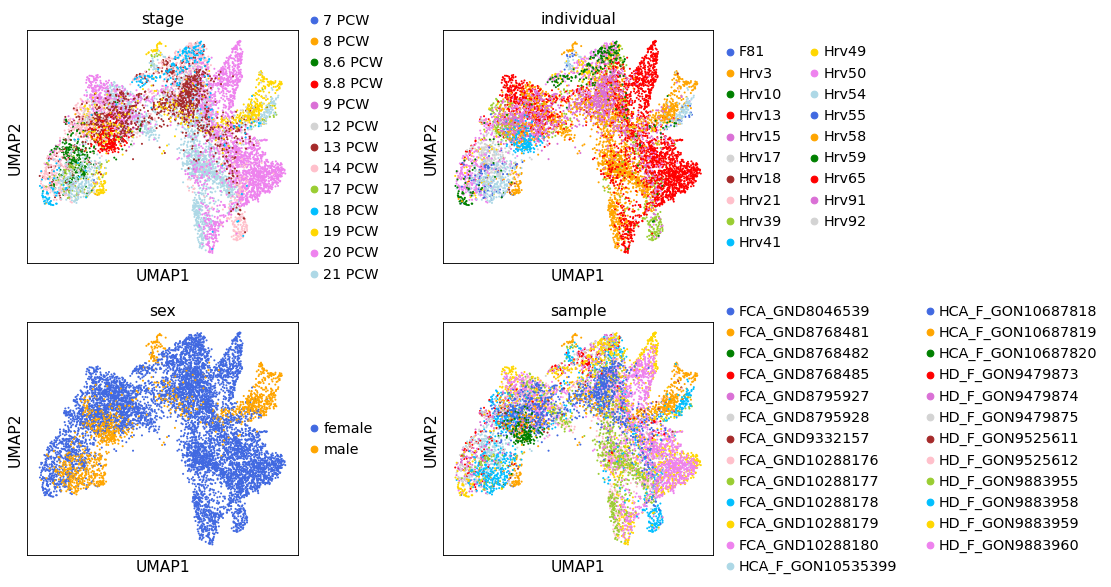

In [23]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sex', 'sample'], ncols = 2, wspace = 0.4, 
          save = "_noharmony.pdf")

In [25]:
gene_data.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample',
       'sex', 'stage', 'individual', 'PGC', 'GC', 'oocyte', 'pre_oocyte',
       'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max'],
      dtype='object')

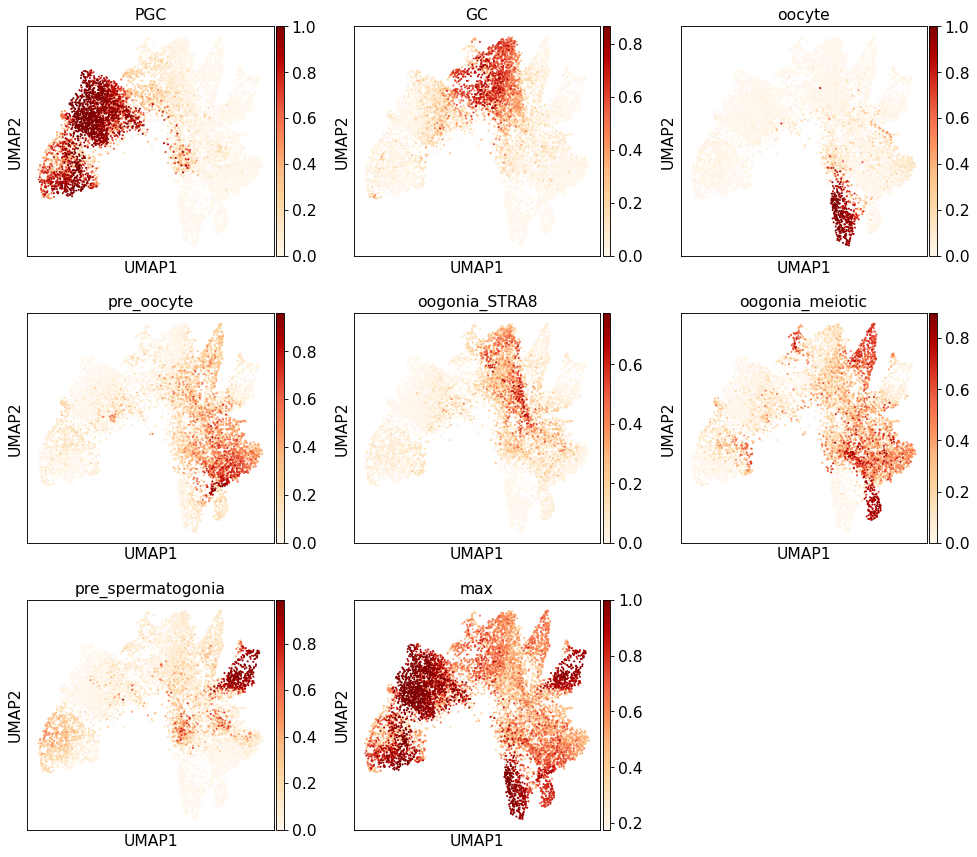

In [26]:
sc.pl.umap(gene_data, color = ['PGC', 'GC', 'oocyte', 'pre_oocyte', 'oogonia_STRA8', 'oogonia_meiotic',
       'pre_spermatogonia', 'max'], ncols = 3, color_map = 'OrRd', save = "_probs_noharmony.pdf")

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [27]:
gene_data.X

array([[91., 36., 36., ...,  2.,  2.,  5.],
       [67., 21., 21., ...,  1.,  1.,  2.],
       [65., 18., 18., ...,  1.,  1.,  2.],
       ...,
       [70., 43., 43., ...,  3.,  1.,  5.],
       [67., 19., 19., ...,  2.,  1.,  5.],
       [60., 19., 19., ...,  2.,  1.,  6.]], dtype=float32)

In [28]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([64.868095, 68.00828 , 67.37366 , ..., 67.380486, 66.60719 ,
       65.1429  ], dtype=float32)

In [29]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

mean_gene_activity
01-AAACAGCCAGCCAGAA-1           64.868095
01-AAACAGCCATCCAGGT-1           68.008278
01-AAACATGCATTGTCCT-1           67.373657
01-AAACCGAAGCTTCCCG-1           65.851418
01-AAACCGAAGGCGAATA-1           67.941391

In [30]:
gene_data.obs['mean_gene_activity'] = means

In [31]:
# sc.pl.umap(gene_data, color = ['mean_gene_activity', 'CKS1B', 'SMC4', 'KIF11'], ncols = 2, color_map = "OrRd")

In [32]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'PCNA', 'MCM2', 'RRM1', 'UNG', 'GINS2', 'DTL', 'UHRF1', 'HELLS', 'RFC2', 'NASP', 'WDR76', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
['NUSAP1', 'BIRC5', 'TPX2', 'CENPF', 'TACC3', 'SMC4', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'GTSE1', 'HJURP', 'HN1', 'CDC20', 'CDC25C', 'KIF2C', 'RANGAP1', 'DLGAP5', 'CDCA2', 'ECT2', 'KIF23', 'HMMR', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'CENPA']


In [33]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [34]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [35]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [36]:
gene_data

AnnData object with n_obs × n_vars = 8901 × 16550
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max', 'mean_gene_activity'
    var: 'gene_id'
    uns: 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_30', 'X_umap'
    obsp: 'connectivities', 'distances'

**Save the predicted annotations to the peaks anndata object for ATAC**

In [37]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 8901 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_GermCells_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_30', 'X_umap'
    varm: 'peak2

In [38]:
adata.obs = adata.obs.drop([ 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max'], axis = 1)

In [39]:
for pred in gene_data.obs.columns: 
    if pred in ['PGC', 'GC', 'oocyte', 'pre_oocyte', 'oogonia_STRA8', 'oogonia_meiotic',
       'pre_spermatogonia', 'max']:
        print(pred)
        adata.obs[pred] = gene_data.obs[pred]

PGC
GC
oocyte
pre_oocyte
oogonia_STRA8
oogonia_meiotic
pre_spermatogonia
max


In [40]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

In [355]:
adata = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

In [356]:
adata.obs['multiome_GermCells'].value_counts()

nan                 3296
oogonia_STRA8       2085
PGC                 1568
oogonia_meiotic     1125
preOocyte            289
preSpermatogonia     176
oocyte               153
PGC_mitotic          119
GC                    90
Name: multiome_GermCells, dtype: int64

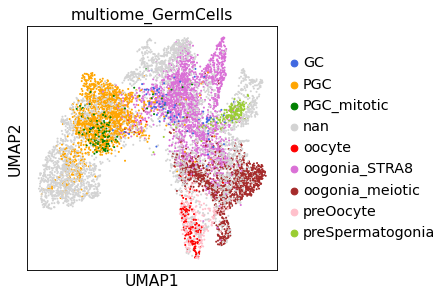

In [357]:
sc.pl.umap(adata, color = 'multiome_GermCells', save = '_nobatch_multiome')

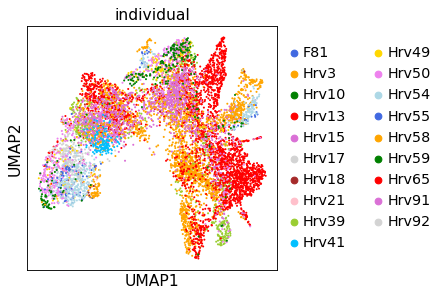

In [288]:
sc.pl.umap(adata, color = 'individual', save = '_nobatch_individual', palette = gonads_colors)

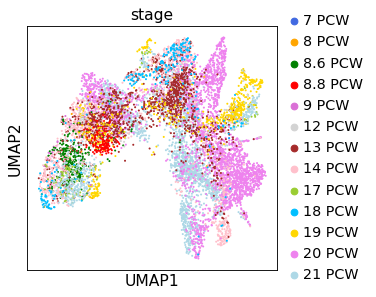

In [289]:
sc.pl.umap(adata, color = 'stage', save = '_nobatch_stage', palette = gonads_colors)

### Harmony integration

In [382]:
adata

AnnData object with n_obs × n_vars = 8901 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_GermCells_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap', 'germ_colors'
    obsm: 'X_cistopic_30', 'X_umap'
 

In [383]:
# Extract PCA matrix and batch array
n_pcs = 30
pca = adata.obsm['X_cistopic_30'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [384]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0,  do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [385]:
# Add harmony values to the anndata object
adata.obsm['X_harmony'] = hem.values

In [386]:
sc.pp.neighbors(adata,n_neighbors=8, use_rep= 'X_harmony', random_state=1234)

In [394]:
sc.tl.umap(adata,  min_dist = 0.3, spread = 1.4)

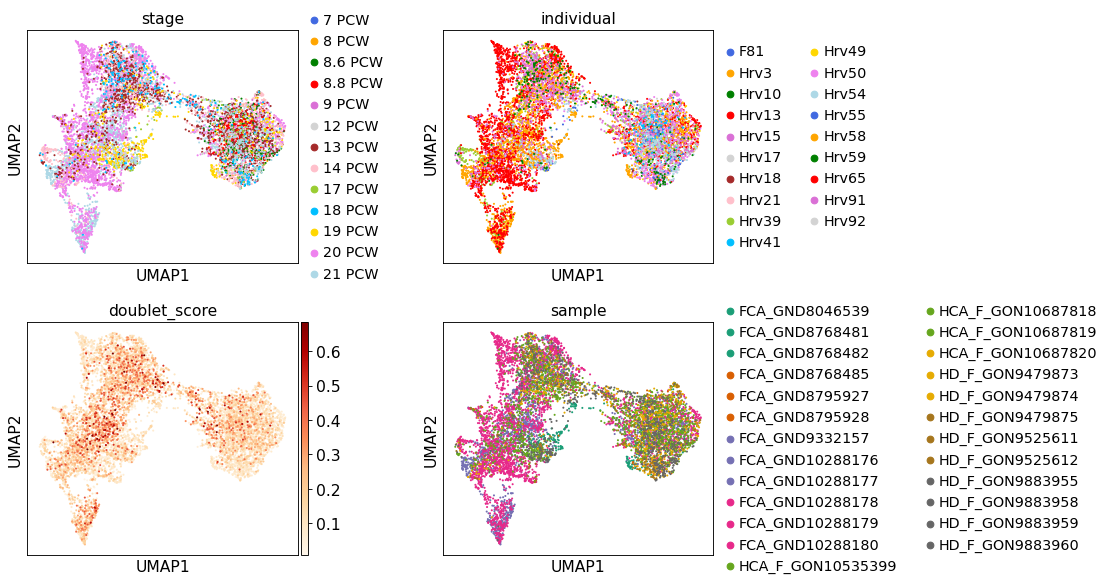

In [395]:
sc.pl.umap(adata, color = ['stage', 'individual', 'doublet_score', 'sample'], ncols = 2, wspace = 0.4, 
           save = "metadata.pdf", color_map = 'OrRd')

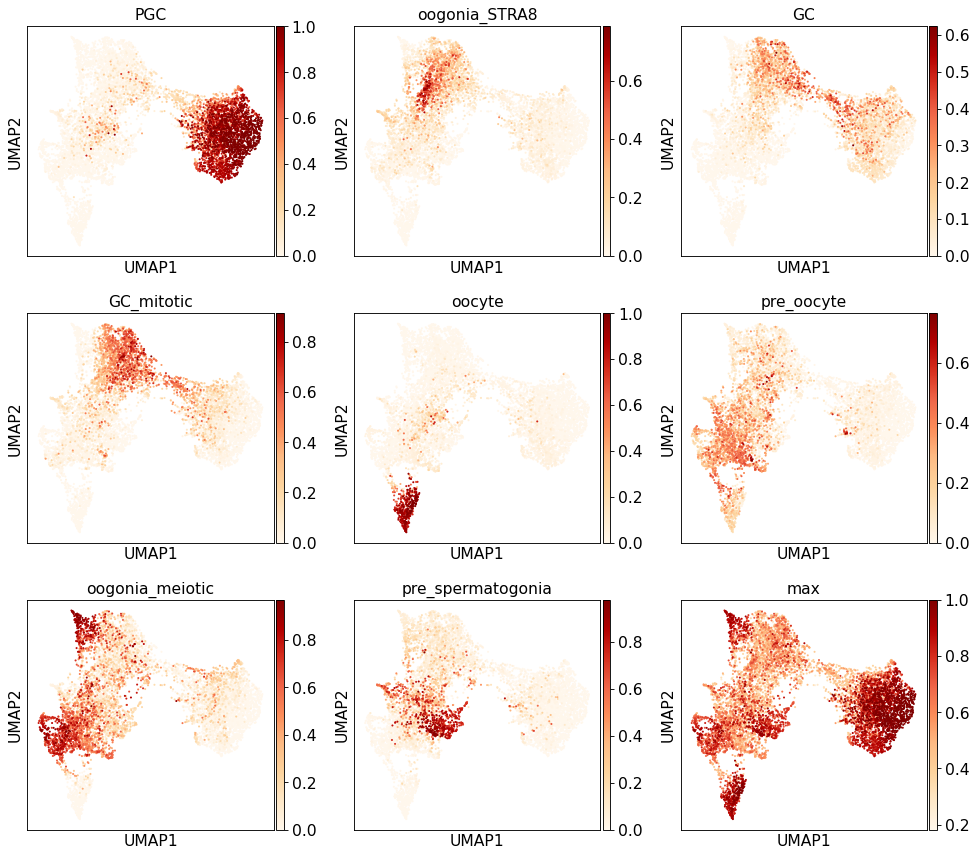

In [396]:
sc.pl.umap(adata, color = ['PGC', 'oogonia_STRA8', 'GC', 'GC_mitotic', 'oocyte',
       'pre_oocyte', 'oogonia_meiotic', 'pre_spermatogonia', 'max'],
           ncols = 3, color_map = 'OrRd', save = "_probs_harmony.pdf")

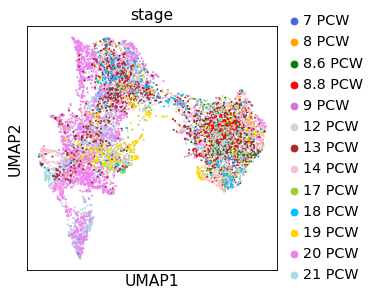

In [397]:
sc.pl.umap(adata, color = 'stage', save = '_batch_stage', palette = gonads_colors)

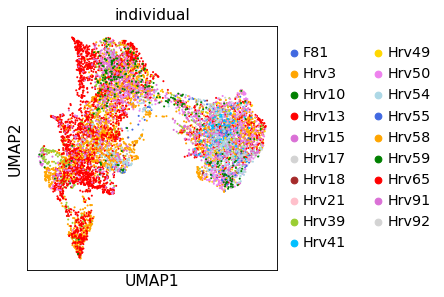

In [398]:
sc.pl.umap(adata, color = 'individual', save = '_batch_individual', palette = gonads_colors)

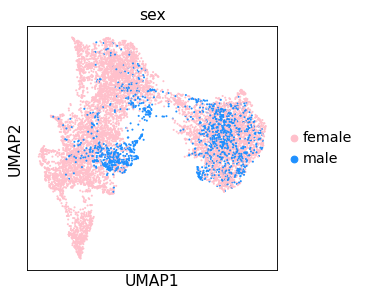

In [399]:
sc.pl.umap(adata, color = 'sex', palette = ['pink', 'dodgerblue'], save = '_batch_sex')

In [75]:
adata.obs['multiome_GermCells'] = ['pre_oocyte' if i == 'preOocyte' else i for i in adata.obs['multiome_GermCells']]
adata.obs['multiome_GermCells'] = ['pre_spermatogonia' if i == 'preSpermatogonia' else i for i in adata.obs['multiome_GermCells']]

In [12]:
adata.obs['multiome_GermCells'] = ['PGC' if i == 'PGC_mitotic' else i for i in adata.obs['multiome_GermCells']]

In [13]:
adata.obs['multiome_GermCells'].value_counts()

nan                  3296
oogonia_STRA8        2085
PGC                  1687
oogonia_meiotic      1125
pre_oocyte            289
pre_spermatogonia     176
oocyte                153
GC                     90
Name: multiome_GermCells, dtype: int64

In [14]:
adata.obs['multiome_GermCells'] = adata.obs['multiome_GermCells'].astype('category')
adata.obs['multiome_GermCells'] = adata.obs['multiome_GermCells'].cat.reorder_categories([
    'PGC', 'GC', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_oocyte', 'oocyte', 'pre_spermatogonia', 'nan'
])

In [15]:
germ_colors = {'PGC' : '#6aa84f', 'oogonia_meiotic' : '#e3cce6', 'oogonia_STRA8' : '#a89ced', 
              'pre_oocyte' : '#ffb3cd', 'oocyte' : '#ff7c73', 'pre_spermatogonia' : '#53b1ed', 'GC' : '#b6d7a8', 
              'nan' : '#f3f3f3'}
adata.uns['germ_colors'] = germ_colors

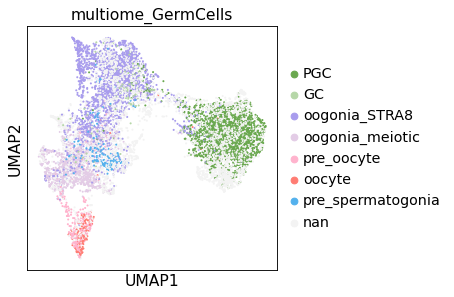

In [16]:
sc.pl.umap(adata, color = 'multiome_GermCells', save = '_batch_multiome', palette = adata.uns['germ_colors'])

In [14]:
old_females = ['FCA_GND10288176', 'FCA_GND10288177', 'FCA_GND10288179', 'FCA_GND10288180']
old_females = adata[[i in old_females for i in adata.obs['sample']]]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


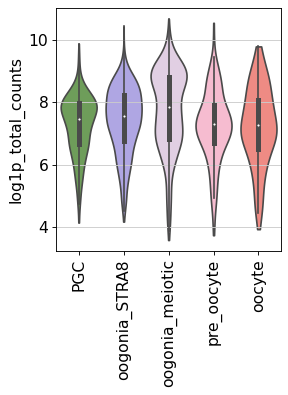

In [15]:
sc.pl.violin(old_females[[i not in ['nan'] for i in old_females.obs['multiome_GermCells']]], keys = ['log1p_total_counts'],
            groupby = 'multiome_GermCells', inner='box', stripplot=False, rotation = 90, save = True)

In [17]:
medianprops = dict(linestyle='-', linewidth=2, color='r')

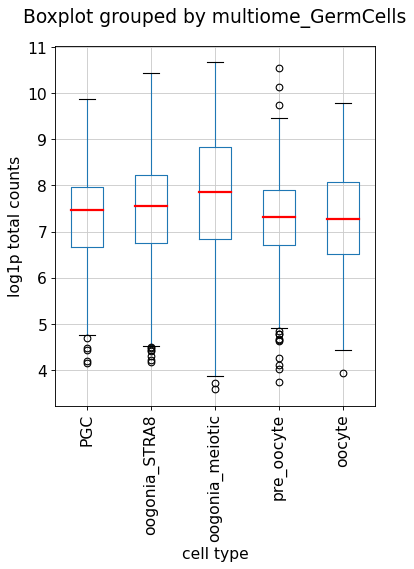

In [18]:
box = old_females[[i not in ['nan'] for i in old_females.obs['multiome_GermCells']]].obs.boxplot(column='log1p_total_counts', 
            by='multiome_GermCells', rot=90, medianprops=medianprops)
box.set_xlabel('cell type')
box.set_ylabel('log1p total counts')
box.set_title("")
box.figure.set_size_inches(5, 6)
box.figure.savefig('/home/jovyan/MULTIOME_july2021/figures_germ/boxplot.pdf', dpi = 300)

#### Visualize position in the manifold of dual ATAC samples

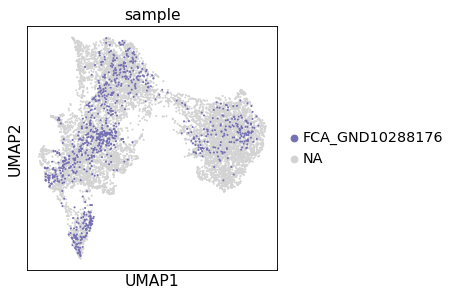

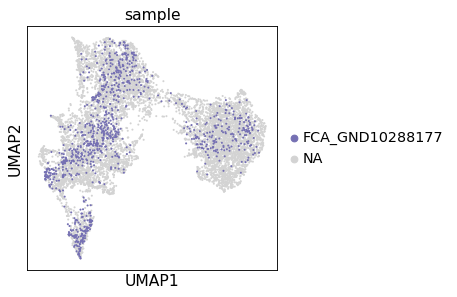

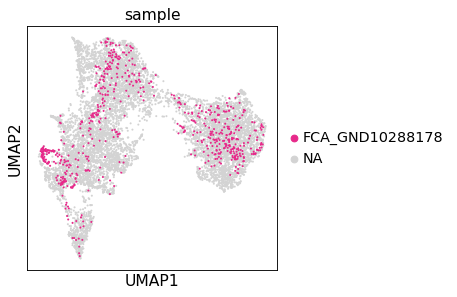

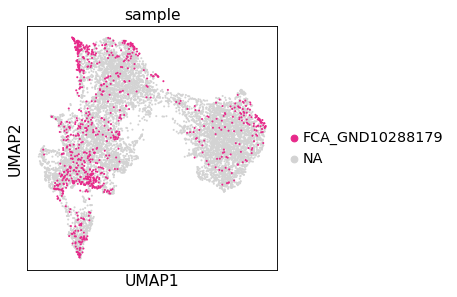

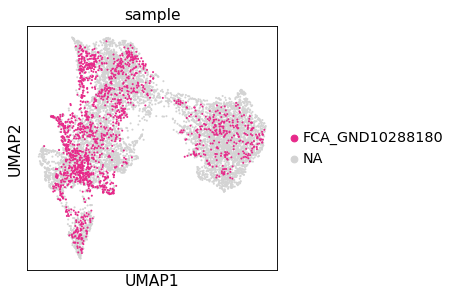

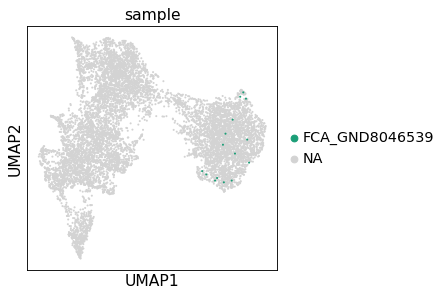

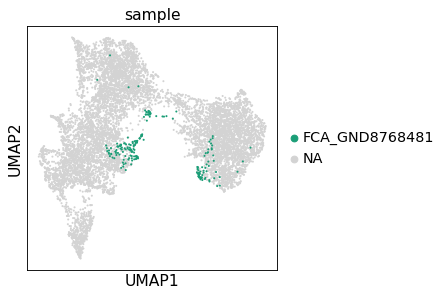

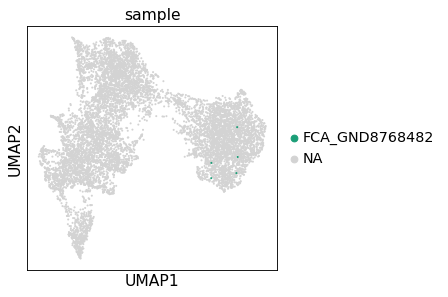

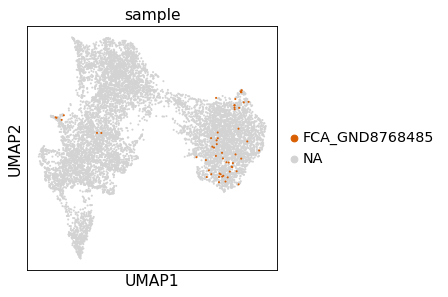

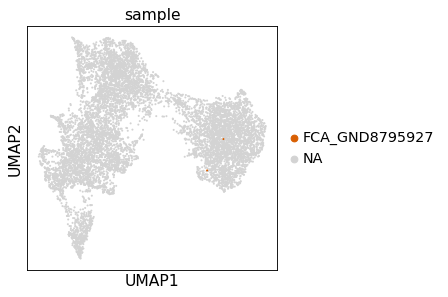

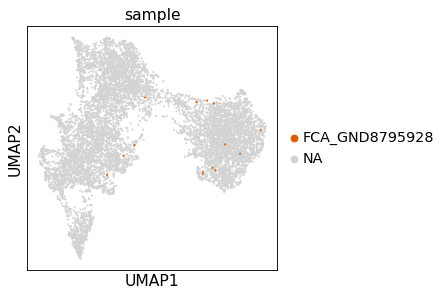

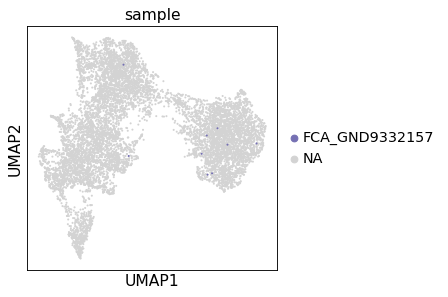

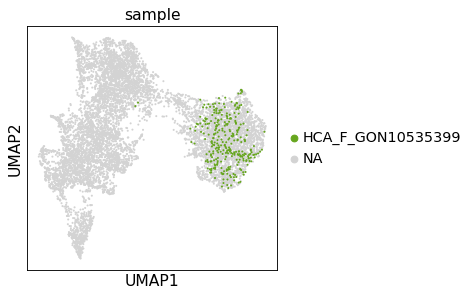

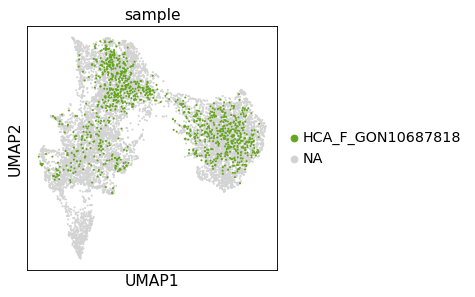

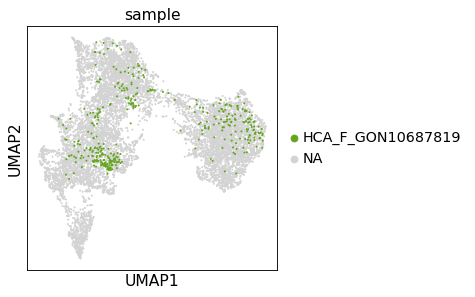

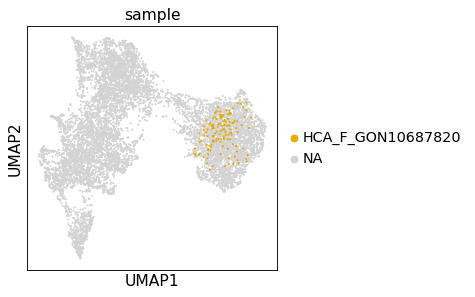

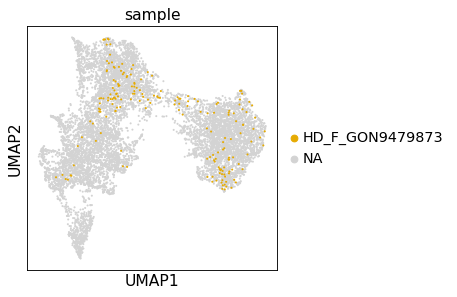

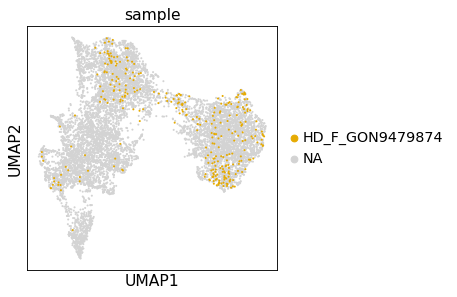

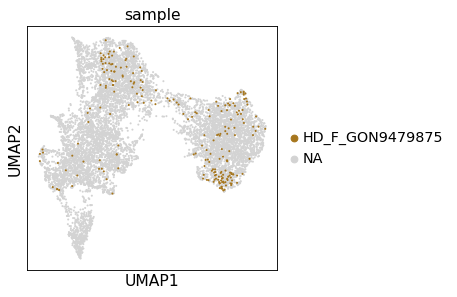

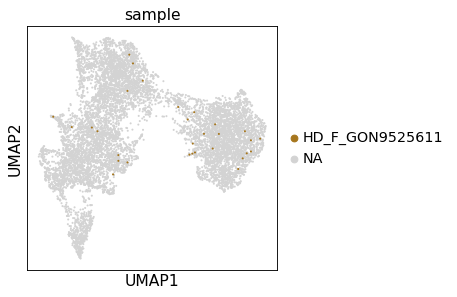

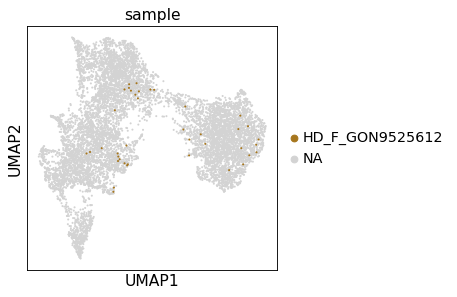

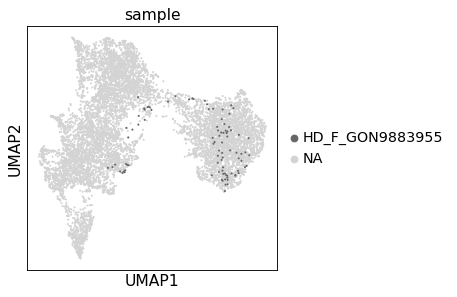

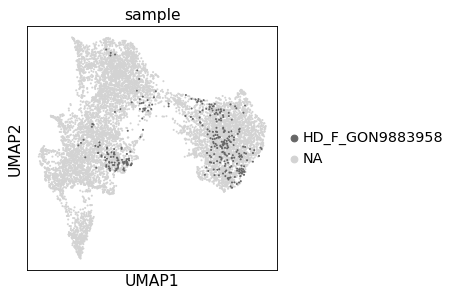

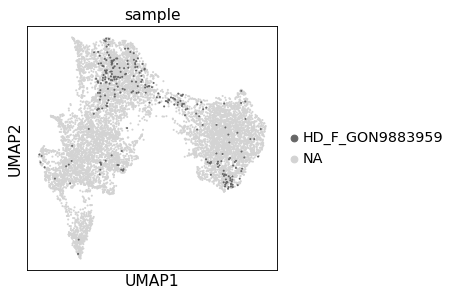

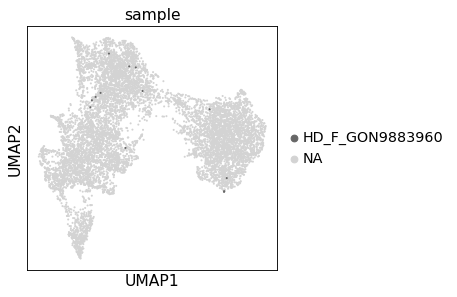

In [408]:
for sample in np.unique(adata.obs['sample']):
    sc.pl.umap(adata, color = 'sample', groups = sample, palette = 'Dark2', save = sample + ".pdf")

#### Clustering

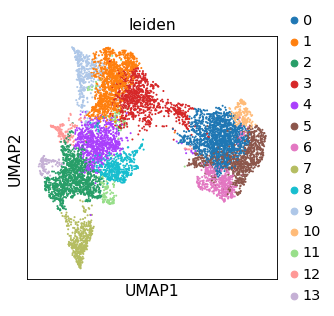

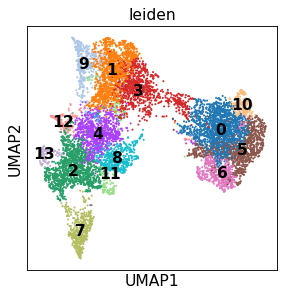

In [414]:
sc.tl.leiden(adata, resolution= 0.8, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf')

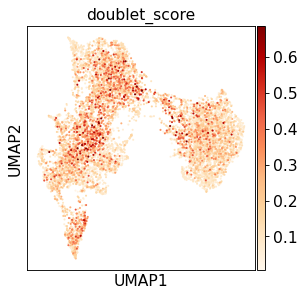

In [415]:
sc.pl.umap(adata, color = ['doublet_score'], color_map = 'OrRd')

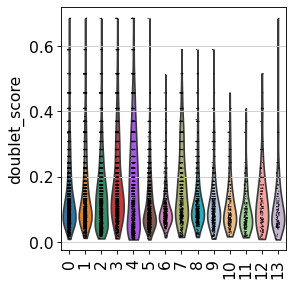

In [416]:
sc.pl.violin(adata, keys = ['doublet_score'], groupby = 'leiden', rotation = 90)

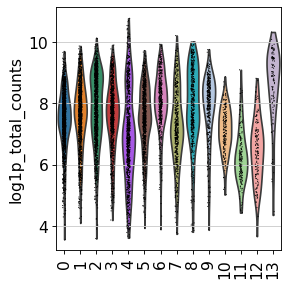

In [418]:
sc.pl.violin(adata, keys = ['log1p_total_counts'], groupby = 'leiden', rotation = 90)

In [419]:
adata

AnnData object with n_obs × n_vars = 8901 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'multiome_GermCells_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap', 'germ_colors'
    obsm: 'X_cistopic_30', 'X_umap', 

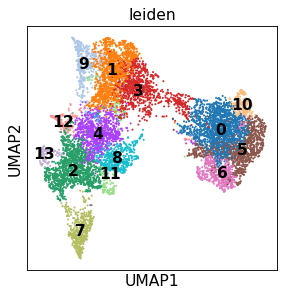

In [420]:
sc.pl.umap(adata, color='leiden',save='_clustering.pdf', legend_loc = 'on data')

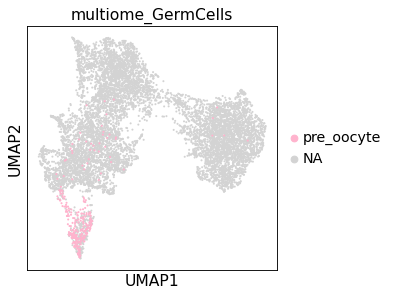

In [421]:
sc.pl.umap(adata, color='multiome_GermCells', groups = 'pre_oocyte')

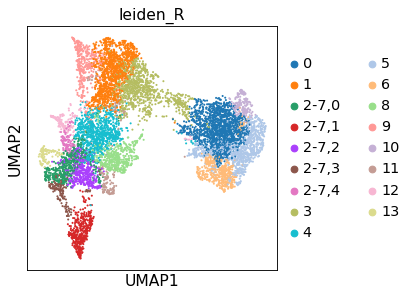

In [425]:
sc.tl.leiden(adata, resolution = 0.4, restrict_to = ('leiden', ['2', '7']))
sc.pl.umap(adata, color = 'leiden_R')

In [426]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

In [10]:
adata = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

In [43]:
for col in ['PGC', 'GC', 'oocyte', 'pre_oocyte', 'GC_mitotic', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max']:
    del adata.obs[col]

In [44]:
for pred in predicted_probabilities.columns: 
    print(pred)
    adata.obs[pred] = predicted_probabilities[pred]

PGC
GC
oocyte
pre_oocyte
oogonia_STRA8
oogonia_meiotic
pre_spermatogonia
max


In [53]:
adata

AnnData object with n_obs × n_vars = 8901 × 120127
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'leiden_R', 'PGC', 'GC', 'oocyte', 'pre_oocyte', 'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'germ_colors', 'individual_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'multiome_GermCells_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopi

#### Matrixplot of label transfer predictions vs leiden clusters

In [63]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'multiome_GermCells', 'code', 'sample',
       'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75',
       'leiden', 'leiden_R', 'PGC', 'GC', 'oocyte', 'pre_oocyte',
       'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia', 'max',
       'cell_type'],
      dtype='object')

In [64]:
obs = adata.obs[[  'PGC', 'GC', 'oocyte', 'pre_oocyte',
       'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia'
       ]]

In [65]:
matrix = obs[[ 'PGC', 'GC', 'oocyte', 'pre_oocyte',
       'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia'
       ]].values
matrix.shape

(8901, 7)

In [66]:
plotting_obs = adata.obs[['leiden_R', 'cell_type']]
plotting_obs.shape

(8901, 2)

In [67]:
plotting_probs = [  'PGC', 'GC', 'oocyte', 'pre_oocyte',
       'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia'
       ]
plotting_var_dict = {'probs' : plotting_probs, 'random_string' : [str(i) for i in range(7)]}
plotting_var = pd.DataFrame(plotting_var_dict)
plotting_var = plotting_var.set_index('probs')
plotting_var.head()
plotting_var.shape

(7, 1)

In [68]:
plotting_adata = anndata.AnnData(X = matrix, obs = plotting_obs, var = plotting_var)
plotting_adata

AnnData object with n_obs × n_vars = 8901 × 7
    obs: 'leiden_R', 'cell_type'
    var: 'random_string'

In [72]:
ordered_probs = [ 'PGC', 'GC',  'oogonia_STRA8',  'oogonia_meiotic', 'pre_oocyte', 'oocyte',
     'pre_spermatogonia']

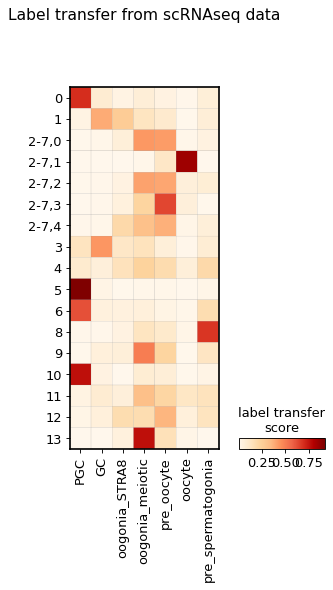

In [73]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'leiden_R', cmap = 'OrRd',
                  save = '_leiden.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

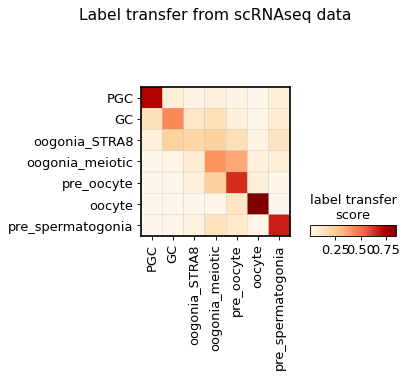

In [74]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

... storing 'cell_type' as categorical


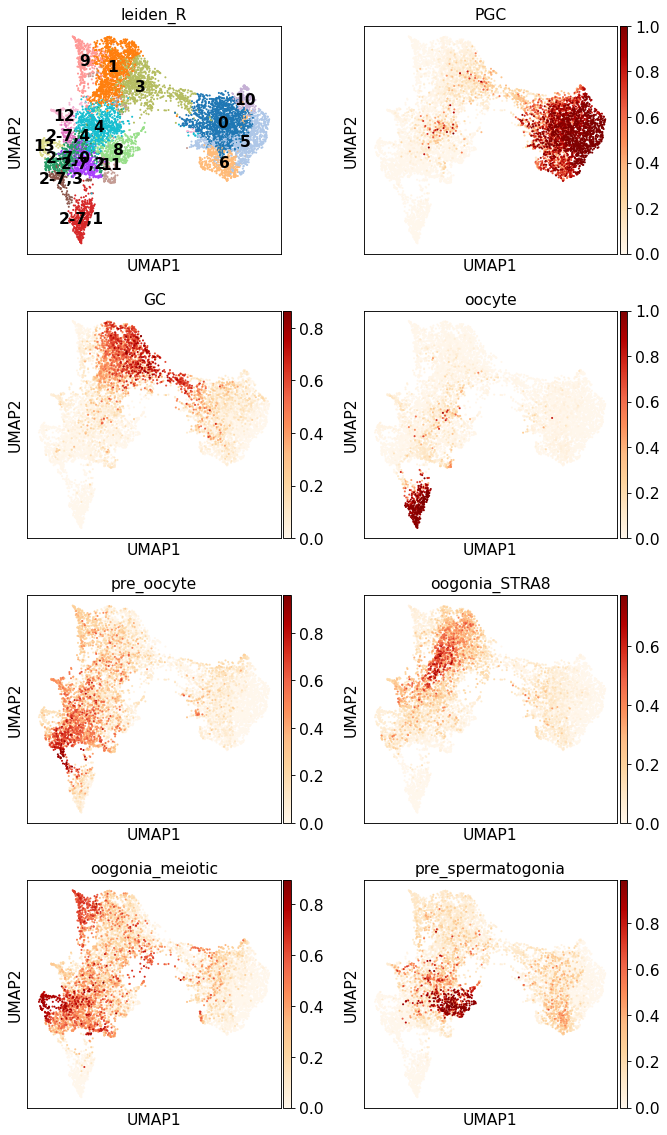

In [55]:
sc.pl.umap(adata, color=['leiden_R',  'PGC', 'GC', 'oocyte', 'pre_oocyte',
       'oogonia_STRA8', 'oogonia_meiotic', 'pre_spermatogonia'
                        ], ncols = 2, color_map = 'OrRd', legend_loc = 'on data')

#### Annotate cells based on label transfer + dual RNA annotations

In [56]:
cell_type = {'0' : 'PGC', '10' : 'PGC', '5' : 'PGC', '6' : 'PGC', '3' : 'GC', 
             '2-7,3' : 'pre_oocyte', '2-7,1' : 'oocyte', '1' : 'oogonia_STRA8', '9' : 'oogonia_STRA8', '4' : 'oogonia_STRA8',
             '13' : 'oogonia_meiotic', '8' : 'pre_spermatogonia', '11' : 'oogonia_meiotic',
             '12' : 'oogonia_meiotic', '2-7,0' : 'oogonia_meiotic', '2-7,2' : 'oogonia_meiotic', 
             '2-7,4' : 'oogonia_meiotic'
            }
adata.obs['cell_type'] = adata.obs['leiden_R'].map(cell_type)
adata.obs['cell_type'].value_counts(dropna = False)

PGC                  3016
oogonia_STRA8        2467
oogonia_meiotic      1466
GC                    903
pre_spermatogonia     459
oocyte                442
pre_oocyte            148
Name: cell_type, dtype: int64

In [57]:
np.unique(adata.obs['cell_type'])

array(['GC', 'PGC', 'oocyte', 'oogonia_STRA8', 'oogonia_meiotic',
       'pre_oocyte', 'pre_spermatogonia'], dtype=object)

In [58]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories([
    'PGC', 'GC',  'oogonia_STRA8', 'oogonia_meiotic',
        'pre_oocyte','oocyte', 'pre_spermatogonia'
])

In [59]:
my_color_dict = {'PGC' : '#6aa84f', 'oogonia_meiotic' : '#e3cce6', 'oogonia_STRA8' : '#a89ced', 
                'pre_oocyte' : '#ffb3cd', 'oocyte' : '#ff7c73', 'pre_spermatogonia' : '#53b1ed',
                'GC' : '#b6d7a8', 'GC_mitotic' : '#79bd5e'}

adata.uns['germcells_colors'] = my_color_dict

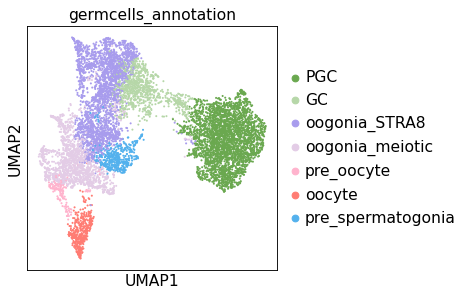

In [60]:
sc.pl.umap(adata, color = 'cell_type', palette = adata.uns['germcells_colors'], 
           legend_fontsize = "medium", legend_fontweight = "medium", frameon = True, 
           title = "germcells_annotation",
           save = "_annotations_germcells.pdf", )

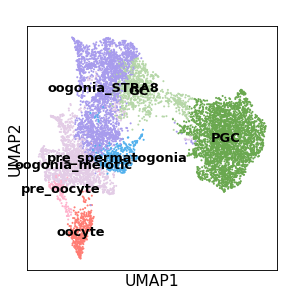

In [61]:
sc.pl.umap(adata, color = 'cell_type', palette = adata.uns['germcells_colors'], 
           legend_fontsize = "small", legend_fontweight = "bold", frameon = True, legend_loc = 'on data',
           title = " ",
           save = "_annotations_germcells_ondata.pdf", )

In [62]:
adata.write(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

#### End of notebook

In [11]:
adata = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")